# Import Libraries

In [1]:
pip install rdkit mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00


In [41]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import shap
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import joblib
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from IPython.display import display, HTML
import seaborn as sns

# Load Models

In [3]:
# load data
drive.mount('/content/drive')

# set working directory
os.chdir('/content/drive/MyDrive/Solubility')

Mounted at /content/drive


In [19]:
# retrieve mlflow experiment details for final model
experiment_name = 'rf_final_model'
client = MlflowClient()

# get experiment ID
experiment = client.get_experiment_by_name(experiment_name)

# get all experiment runs
runs = client.search_runs(experiment.experiment_id)

# get most recent run
run = runs[0]
run_id = run.info.run_id
artif_uri = runs[0].info.artifact_uri

# print info
print("Run ID:", run_id)
print("Artifact URI:", artif_uri)

# load trained model
model_uri = f"runs:/{run_id}/rf_final_model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

Run ID: 734d84cd8a874f0aae8c6725e55bd2bd
Artifact URI: file:///content/drive/MyDrive/Solubility/mlruns/389268190986064492/734d84cd8a874f0aae8c6725e55bd2bd/artifacts


In [5]:
# load SHAP explainer
explainer = joblib.load("explainer.pkl")

# Define Functions for Example Processing

In [6]:
# function to compute molecular descriptors for input molecule
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        st.error("Invalid SMILES string")
        return None

    descriptor_names = [
        "MaxEStateIndex",
        "MinEStateIndex",
        "qed",
        "SPS",
        "MolWt",
        "MaxPartialCharge",
        "MinPartialCharge",
        "FpDensityMorgan2",
        "BCUT2D_MWHI",
        "BCUT2D_CHGHI",
        "BCUT2D_LOGPHI",
        "BCUT2D_MRHI",
        "AvgIpc",
        "BalabanJ",
        "HallKierAlpha",
        "Ipc",
        "Kappa3",
        "TPSA",
        "FractionCSP3",
        "NumAromaticCarbocycles",
        "NumAromaticRings",
        "NumHAcceptors",
        "NumHDonors",
        "NumHeteroatoms",
        "NumRotatableBonds",
        "Phi",
        "RingCount",
        "MolLogP",
    ]

    descriptor_vals = {name: func(mol) for name, func in Descriptors.descList if name in descriptor_names}

    return pd.DataFrame([descriptor_vals])

In [28]:
# define function to get prediction for example molecule and map to solubility categories
def get_prediction(smiles):

  # define target class mapping
  solubility_class_labels = {
    0: "Insoluble (< -4 LogS)",
    1: "Slightly soluble (-4 to -2 LogS)",
    2: "Soluble (> -2 LogS)",
  }

  # get prediction class
  prediction_class = model.predict(descriptors)[0]
  prediction_label = solubility_class_labels[prediction_class]

  # get class probs
  prediction_probs = model.predict_proba(descriptors)[0]
  print(prediction_probs)
  probs_df = pd.DataFrame(
      data=prediction_probs,
      columns=["Insoluble (< -4 LogS)", "Slightly soluble (-4 to -2 LogS)", "Soluble (> -2 LogS)"]
  )
  return prediction_label, probs_df

  #print("\nPredicted Solubility Class:", prediction_class)
  #print("\n Prediction Probability:", prediction_prob[0])

In [59]:
def generate_html_report(smiles, top_k=5):
    # compute descriptors for input molecule
    descriptors_df = compute_descriptors(smiles)
    if descriptors_df is None:
        return "<p>Invalid SMILES string. Please try again.</p>"

    # map descriptors to interpretable names
    descriptor_labels = {
      "MolWt": "Molecular Weight",
      "MolLogP": "LogP",
      "TPSA": "Topological Polar Surface Area",
      "qed": "QED (Drug-likeness)",
      "FractionCSP3": "Fraction sp3 Carbons",
      "NumHAcceptors": "H-Bond Acceptor Count",
      "NumHDonors": "H-Bond Donor Count",
      "RingCount": "Ring Count",
      "FpDensityMorgan2": "Fragment Density",
      "BalabanJ": "Molecular Complexity (BalabanJ)",
      "MaxEStateIndex": "Max E-State Index",
      "MinEStateIndex": "Min E-State Index",
      "Phi": "Phi (Flexibility)",
      "SPS": "Simple Polar Surface"
    }

    # get molecule structure
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(300, 300))
    buf = BytesIO()
    img.save(buf, format="PNG")
    img_data = base64.b64encode(buf.getvalue()).decode()
    img_html = f'<img src="data:image/png;base64,{img_data}" alt="Molecule Structure" style="max-width: 300px;">'

    # define target class mapping
    solubility_class_labels = {
      0: "Insoluble (< -4 LogS)",
      1: "Slightly soluble (-4 to -2 LogS)",
      2: "Soluble (> -2 LogS)"
    }

    # get predictions and probabilities
    predicted_class = model.predict(descriptors_df)[0]
    predicted_label = solubility_class_labels[predicted_class]
    probabilities = model.predict_proba(descriptors_df)[0]
    prob_df = pd.DataFrame(
        data=[probabilities],
        columns=["Insoluble", "Slightly soluble", "Soluble"]
    )
    prob_html = prob_df.to_html(index=False, float_format="%.2f")

    # generate SHAP waterfall plot
    shap_values = explainer(descriptors_df)

    # map feature names to interpretable labels
    shap_df = pd.DataFrame({
        "Feature": descriptors_df.columns,
        "SHAP Value": shap_values.values[0],
        "Feature Value": descriptors_df.iloc[0].values
    })
    shap_df["Feature"] = shap_df["Feature"].map(descriptor_labels).fillna(shap_df["Feature"])

    # sort by absolute SHAP value
    shap_df["Abs SHAP Value"] = shap_df["SHAP Value"].abs()
    shap_df = shap_df.sort_values(by="Abs SHAP Value", ascending=False).head(top_k)

    # add color label for hue
    shap_df["Contribution"] = ["Decreases Solubility" if val < 0 else "Increases Solubility" for val in shap_df["SHAP Value"]]

    # create the waterfall plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        y=[f"{feat} ({val:.2f})" for feat, val in zip(shap_df["Feature"], shap_df["Feature Value"])],
        x=shap_df["SHAP Value"],
        hue=shap_df["Contribution"],
        palette={"Decreases Solubility": "#E74C3C", "Increases Solubility": "#2ECC71"},
        dodge=False
    )
    plt.title(f"Top {top_k} SHAP Feature Contributions")
    plt.xlabel("Impact on Solubility")
    plt.ylabel("Descriptor (Value)")
    plt.axvline(0, color="black", linewidth=0.8)
    plt.tight_layout()
    shap_html_path = "shap_waterfall.png"
    plt.savefig(shap_html_path, bbox_inches="tight", dpi=300)
    plt.close()

    # convert the SHAP plot to base64
    with open(shap_html_path, "rb") as f:
        shap_img_data = base64.b64encode(f.read()).decode()
    shap_img_html = f'<img src="data:image/png;base64,{shap_img_data}" alt="SHAP Waterfall" style="max-width: 600px;">'

    # generate final HTML report
    html_content = f"""
    <html>
    <head><style>body {{ font-family: Arial, sans-serif; line-height: 1.6; }}</style></head>
    <body>
    <h2>Molecule Report</h2>
    {img_html}
    <h3>Predicted Solubility Class: {predicted_label}</h3>
    <h4>Class Probabilities</h4>
    {prob_html}
    <h4>SHAP Waterfall Plot</h4>
    {shap_img_html}
    </body>
    </html>
    """

    # display the report in the notebook
    display(HTML(html_content))

# Example

Insoluble,Slightly soluble,Soluble
0.00,0.23,0.78

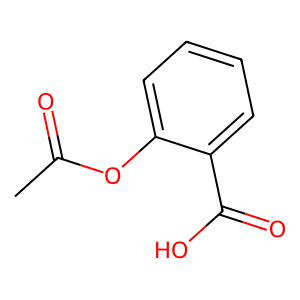
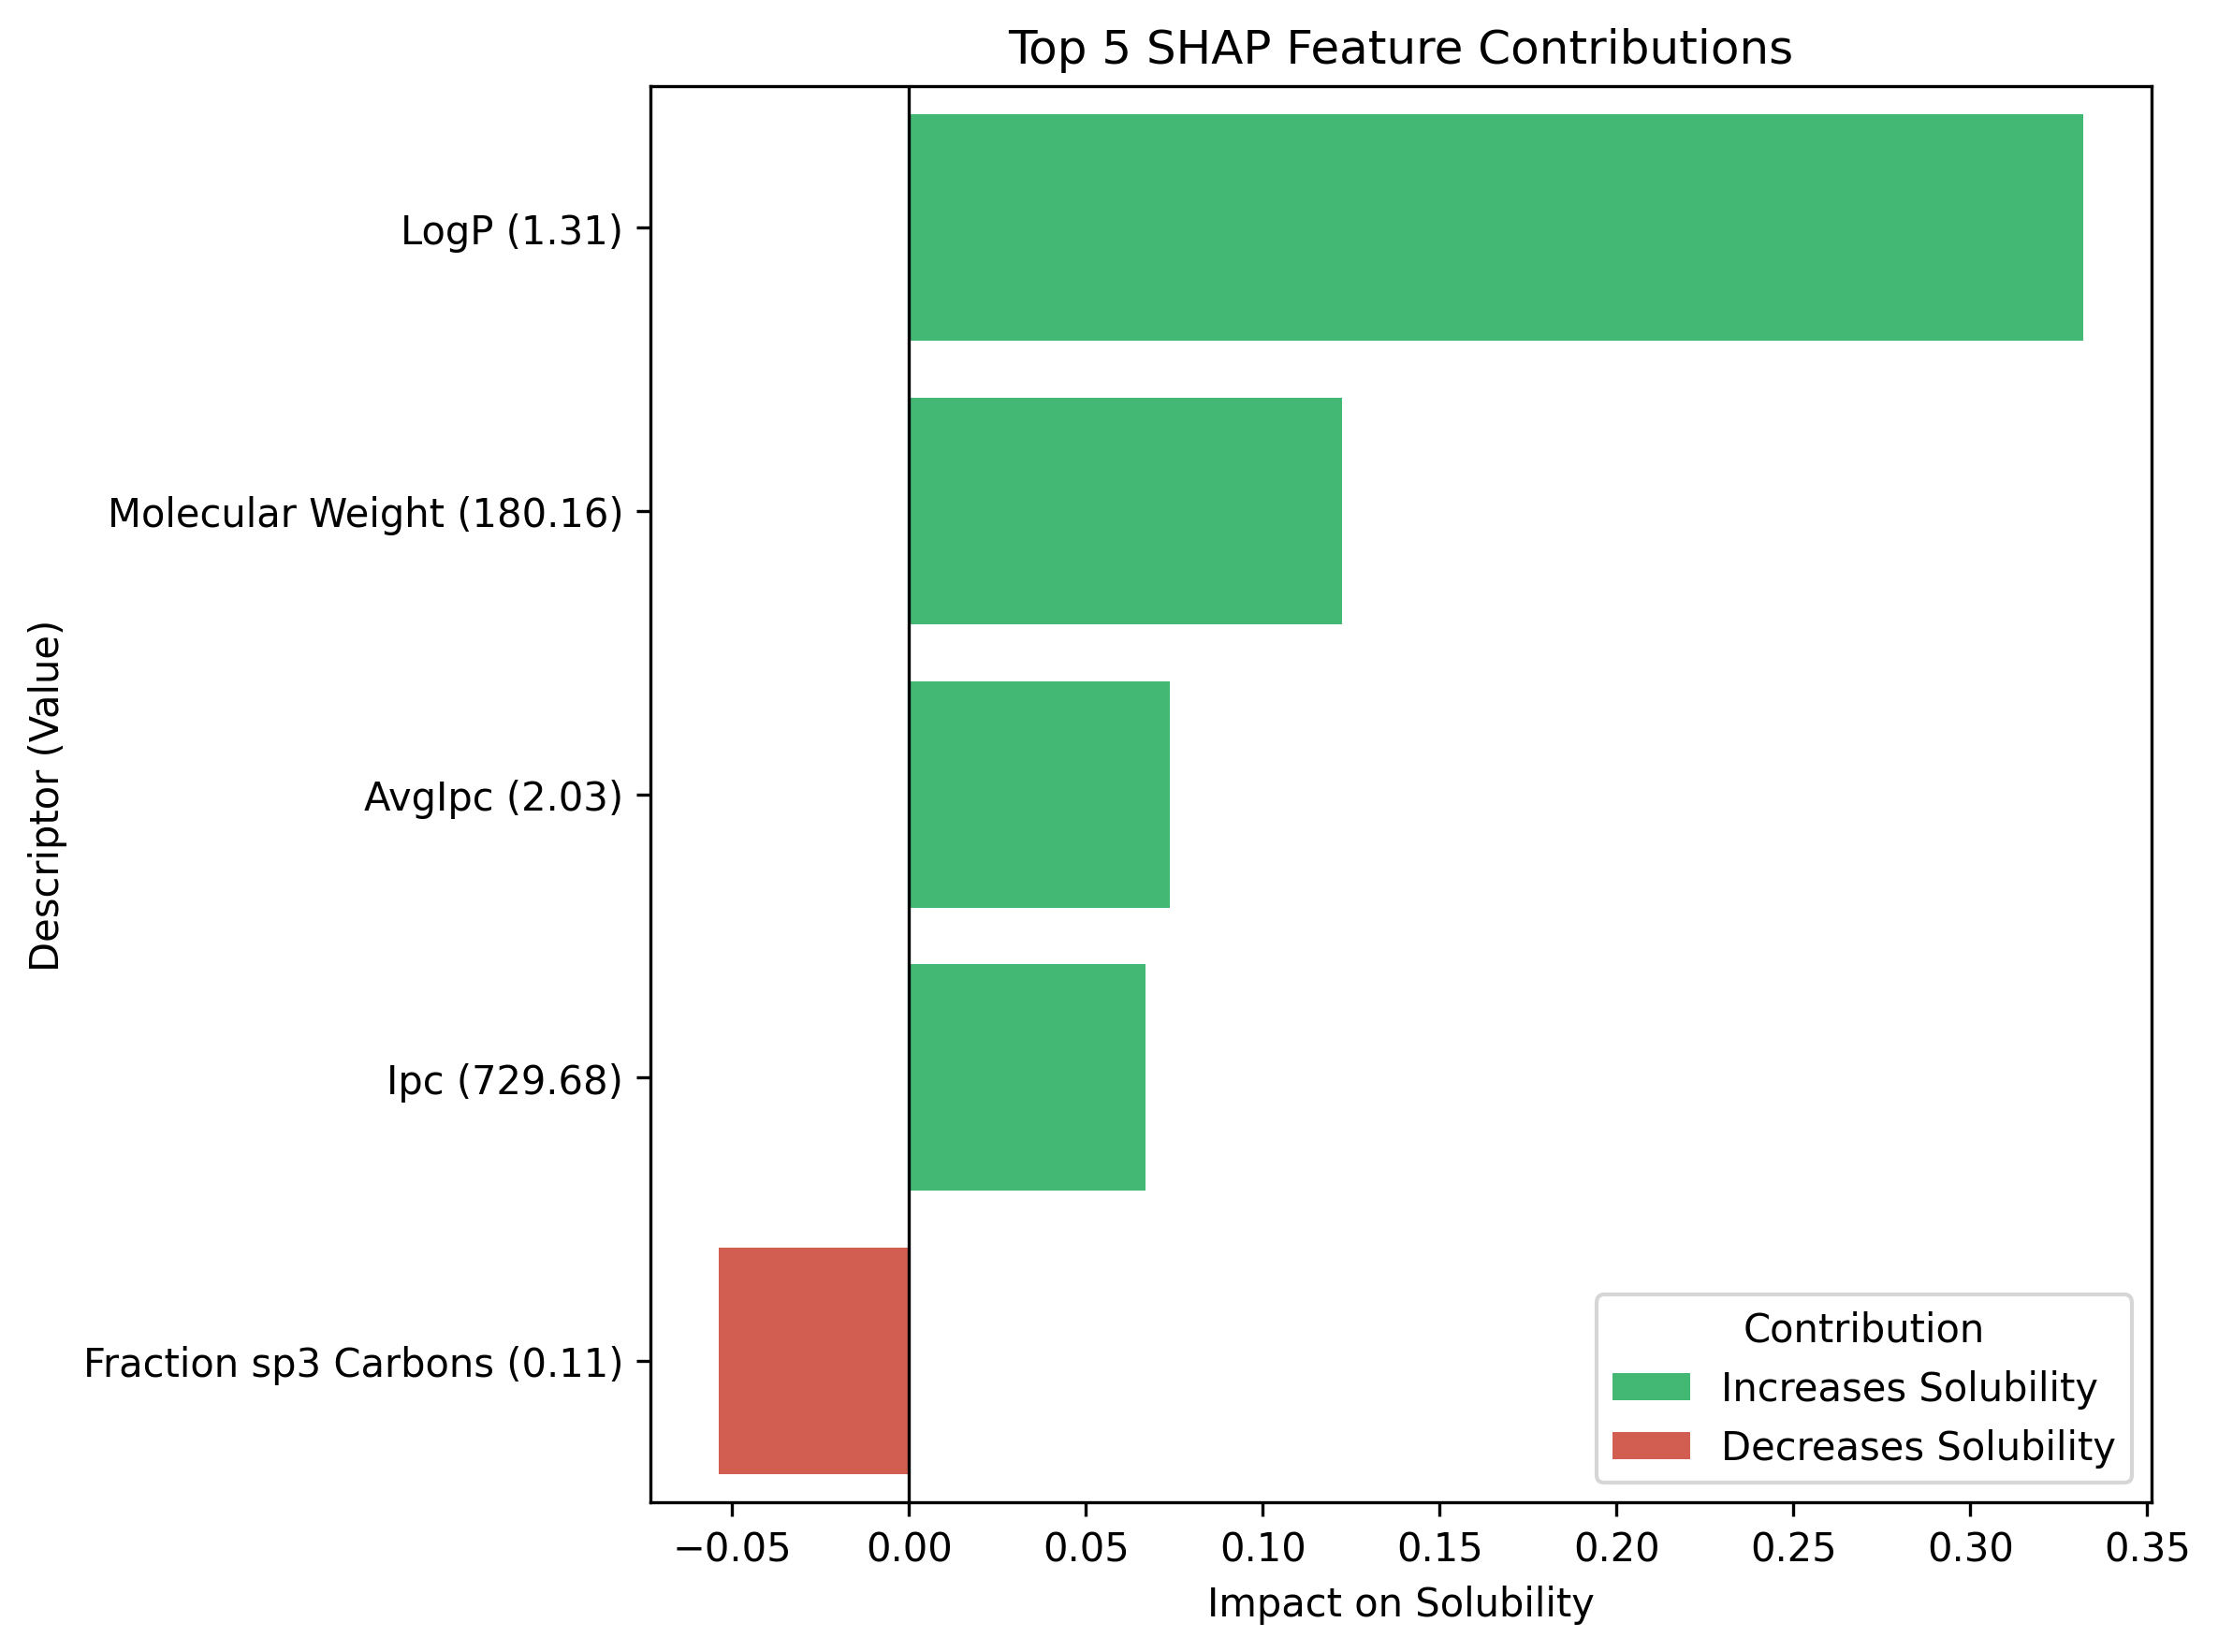

In [90]:
# provide input smiles and generate report
smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O' # Aspirin
generate_html_report(smiles)